### Look at periportal and pericentral hepatocyte/endothelial cell spatial statistics

In [20]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import anndata as ad
import scanpy as sc
import seaborn as sns
from fs import open_fs
from matplotlib import patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar
from tqdm import tqdm
from skimage.measure import block_reduce
from merlin.core import dataset
import h5py
import tifffile
import string

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')
    
# Function to preprocess raw AnnData object

def preprocess_ad(ad, min_counts):
    ad.layers['counts'] = ad.X.copy()
    sc.pp.filter_cells(ad, min_counts=min_counts)
    sc.pp.normalize_total(ad, target_sum=1e4) # Normalize data
    sc.pp.log1p(ad) # Logarithmize the data
    #sc.pp.scale(ad) # Scale each gene to unit variance

In [5]:
# Load raw MERFISH results
# Define the path of the analyzed data

data_path = '/mnt/ibm_lg/spatial-seq/MERlin_Analysis'

# Define the experiment

experiment_name = 'MsKidney_CellBoundary_VZG116_111921'

d_set = dataset.MERFISHDataSet(experiment_name)
fs = open_fs(os.path.join(data_path, experiment_name))

print('Dataset loaded.')

# decodedTranscripts = pd.read_csv(os.path.join(data_path, experiment_name, 'ExportBarcodes', 'region_0',
#                                              'barcodes.csv'))

# print('Decoded barcodes loaded.')

cell_metadata = pd.read_csv(os.path.join(
    data_path, experiment_name, 'ExportCellMetadata/region_0/feature_metadata.csv'), index_col=0)

print('Cell metadata loaded')

Dataset loaded.
Cell metadata loaded


In [6]:
# Load data
fileDir = '/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/results/'

VizgenKidney = ad.read_h5ad(fileDir + 'MERFISH_kidney_object.h5ad')

# Create abbreviated cell type labels
liver_abbrev_map = {'immune cell': 'IC',
                   'other endothelial cell': 'o-EC',
                   'Kupffer cell': 'KC',
                   'hepatic stellate cell': 'HSC',
                   'other hepatocyte': 'o-hep',
                   'periportal hepatocyte': 'PP-hep',
                   'pericentral hepatocyte': 'PC-hep',
                   'periportal endothelial cell': 'PP-EC',
                   'pericentral endothelial cell': 'PC-EC'}
kidney_abbrev_map = {'epithelial cell of proximal tubule':'EC-PT',
                    'immune cell': 'IC',
                    'pericyte':'per',
                    'kidney loop of Henle epithelial cell':'KLH-EC',
                    'kidney collecting duct epithelial cell':'KCD-EC',
                    'kidney distal convoluted tubule epithelial cell':'KDCT-EC',
                    'endothelial cell': 'EC',
                    'podocyte':'pod',
                    'fibroblast':'fib'}

VizgenKidney.obs['tentative_annot_abv'] = VizgenKidney.obs['tentative_annot'].map(kidney_abbrev_map)

print('Results loaded.')

Results loaded.


In [8]:
# Load alignment parameters to transform between local/global coordinates

globalAlignment = d_set.load_analysis_task('CorrelationGlobalAlignment')

# Load DAPI mosaic
zInd = 3
z_stack = ['z0','z1','z2','z3','z4','z5','z6']
dscale = 20 # Downsampling factor

dapi_mosaic = tifffile.TiffFile(os.path.join(
    data_path, experiment_name, "BlendMosaic", "region_0" , 'mosaic_DAPI_' + z_stack[zInd] + '.tif')).asarray()

# Downsample DAPI mosaic using block reduce for low-res plot
dapi_mosaic_lowres = block_reduce(dapi_mosaic, block_size=(dscale, dscale), func=np.mean)

print('DAPI mosaic loaded.')

DAPI mosaic loaded.


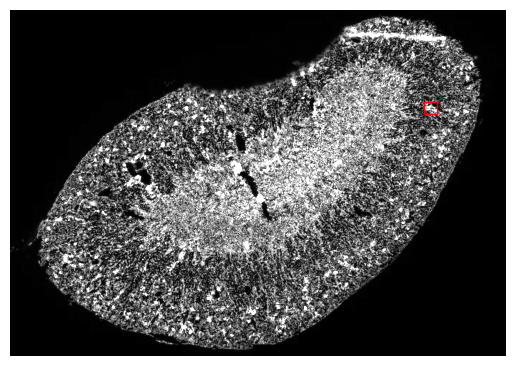

In [47]:
# Plot the DAPI mosaic with red box for a specific FOV
fov = 787

globMinX, globMinY = globalAlignment.fov_coordinates_to_global(fov, (minX, minY))
globMaxX, globMaxY = globalAlignment.fov_coordinates_to_global(fov, (maxX, maxY))

globMinX = globMinX / (dscale * size_of_one_pixel)
globMaxX = globMaxX / (dscale * size_of_one_pixel)
globMinY = globMinY / (dscale * size_of_one_pixel)
globMaxY = globMaxY / (dscale * size_of_one_pixel)

# Create rectangle for zoomed in snippet
rect = mpatches.Rectangle((globMinX, globMinY), globMaxX - globMinX, 
                          globMaxY - globMinY, linewidth=1, edgecolor='r', facecolor='none')

fig, ax = plt.subplots()
ax.imshow(dapi_mosaic_lowres, cmap='gray', vmax=20000)
ax.add_patch(rect)
ax.axis('off')
plt.show()

/tmp/ipykernel_3923353/4285170246.py:25: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  cell_boundaries = h5py.File(current_file)


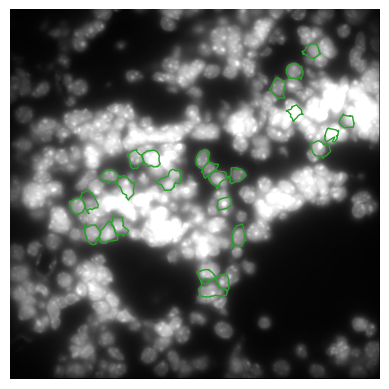

In [63]:
# Plot the zoomed in snippet

zInd = 3
minX = 0
maxX = 2048
minY = 0
maxY = 2048
ch = [0,1,24,28] #Bit 1, Bit 2, CellBound3, and DAPI respectively

# Matrix to transform from global micron coordinates to local fov pixel coordinates
transformation_matrix_2 = np.linalg.inv(globalAlignment.fov_to_global_transform(fov))
size_of_one_pixel = 1 / transformation_matrix_2[0,0]

# Get the warped raw images
warp = d_set.load_analysis_task('FiducialCorrelationWarp')

# Get the indices of the podocytes in this FOV
pod = VizgenKidney[VizgenKidney.obs['tentative_annot_abv'] == 'pod'].obs
pod_fov = pod[pod['fov'] == fov]
pod_ind = pod_fov.index

# Get the boundary segmentation coordinates
current_file = os.path.join(data_path, experiment_name, 
                            'RefineCellDatabases', 'features', 'feature_data_%i.hdf5' % fov)
cell_boundaries = h5py.File(current_file)
current_cells = []
for i in cell_metadata[cell_metadata['fov'] == fov].index:
    if i in cell_boundaries['featuredata'] and 'p_0' in cell_boundaries['featuredata'][i]['zIndex_%i' % zInd]:
        temp = np.array(cell_boundaries['featuredata'][i]['zIndex_%i' % zInd]['p_0']['coordinates'][0])
        boundary_polygon = np.ones((temp.shape[0], temp.shape[1]+1))
        boundary_polygon[:, :-1] = temp
        transformed_boundary = np.matmul(transformation_matrix_2, np.transpose(boundary_polygon))[:-1]
        current_cells.append(transformed_boundary)

fig, ax = plt.subplots()

# DAPI
warped_im = warp.get_aligned_image(fov, ch[3], zInd)
ax.imshow(warped_im, cmap='gray', vmin=0, vmax=40000, origin='lower')

ax.set_xlim(minX, maxX)
ax.set_ylim(minY, maxY)
ax.axis("off")

# Segmented boundaries
for tb in current_cells:
    ax.plot(tb[0], tb[1], 'tab:green', linestyle='-', linewidth=1)
plt.show()

Trying to set attribute `.uns` of view, copying.


<Figure size 640x480 with 0 Axes>

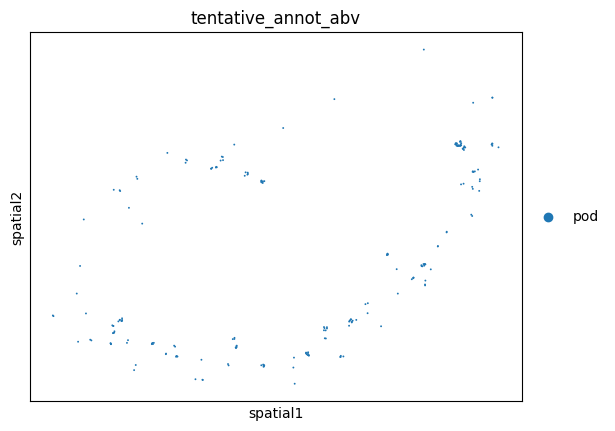

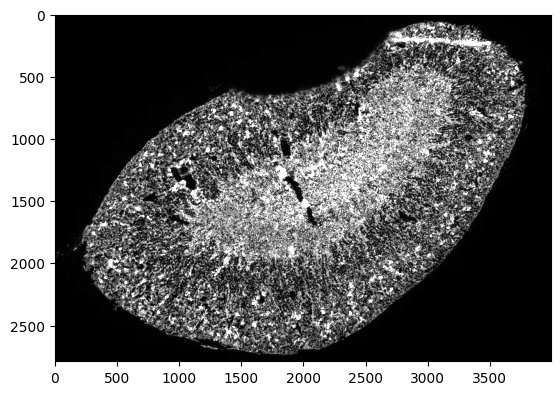

In [40]:
# Plot some specific cell types

plt.figure()
sc.pl.spatial(VizgenKidney[
    VizgenKidney.obs['tentative_annot_abv'].isin(['pod'])], color='tentative_annot_abv', spot_size=30)
plt.imshow(dapi_mosaic_lowres, cmap='gray', vmax=20000)
plt.show()